In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import os

# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set model to evaluation mode

# Define the image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load the ImageNet class index mapping
with open("imagenet_class_index.json") as f:
    class_idx = json.load(f)
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
idx2synset = [class_idx[str(k)][0] for k in range(len(class_idx))]
id2label = {v[0]: v[1] for v in class_idx.values()}

imagenet_path = './imagenet_samples'

# List of image file paths
image_paths = os.listdir(imagenet_path)

for img_path in image_paths:
    # Open and preprocess the image
    my_img = os.path.join(imagenet_path, img_path)
    input_image = Image.open(my_img).convert('RGB')
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    # Move the input and model to GPU if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    # Perform inference
    with torch.no_grad():
        output = model(input_batch)

    # Get the predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()
    predicted_synset = idx2synset[predicted_idx]
    predicted_label = idx2label[predicted_idx]

    print(f"Input image: {img_path}, Predicted label: {predicted_synset} ({predicted_label})")


Input image: paintbrush.JPEG, Predicted label: n04118776 (rule)
Input image: peacock.JPEG, Predicted label: n01806143 (peacock)
Input image: mountain_bike.JPEG, Predicted label: n03792782 (mountain_bike)
Input image: piggy_bank.JPEG, Predicted label: n03938244 (pillow)
Input image: mousetrap.JPEG, Predicted label: n03250847 (drumstick)


In [ ]:
from skimage.segmentation import slic
import numpy as np

def lime_explain(model, pil_img, target_class, num_segments=50, num_samples=5000, sigma=0.25):
    img = np.array(pil_img.resize((224, 224))) / 255.0
    segments = slic(img, n_segments=num_segments, compactness=10, sigma=1)
    num_features = len(np.unique(segments))
    masks = np.random.randint(0, 2, size=(num_samples, num_features))
    masks[0] = 1

    segment_means = {}
    for seg_id in range(num_features):
        mask = segments == seg_id
        segment_means[seg_id] = img[mask].mean(axis=0)

    img_mean = img.mean(axis=(0, 1))
    preds = []
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

    device = next(model.parameters()).device
    if device.type == 'cuda':
        mean = mean.cuda()
        std = std.cuda()

    model.eval()

    for mask in masks:
        # Create perturbed image
        perturbed_img = img.copy()

        for seg_id in range(num_features):
            if mask[seg_id] == 0:
                mask_region = segments == seg_id
                # mask the region to gray color
                perturbed_img[mask_region] = 0.5

        tensor = torch.tensor(perturbed_img.transpose(2, 0, 1)).float().unsqueeze(0)

        if device.type == 'cuda':
            tensor = tensor.cuda()
        tensor = (tensor - mean) / std

        with torch.no_grad():
            output = model(tensor)
            probs = torch.nn.functional.softmax(output, dim=1)
            preds.append(probs[0, target_class].cpu().item())

    preds = np.array(preds)

    original = np.ones(num_features)
    distances = np.sum(np.abs(masks - original), axis=1) / num_features

    kernel_width = sigma * np.sqrt(num_features) * 0.75
    weights = np.exp(-(distances ** 2) / (kernel_width ** 2))

    X = np.column_stack([np.ones(num_samples), masks])
    W = np.diag(weights)
    y = preds

    XtWX = X.T @ W @ X
    XtWX = XtWX + 1e-6 * np.eye(X.shape[1])
    XtWy = X.T @ W @ y

    try:
        coef = np.linalg.solve(XtWX, XtWy)
    except np.linalg.LinAlgError:
        coef = np.linalg.pinv(XtWX) @ XtWy

    feature_importance = coef[1:]

    importance_map = np.zeros_like(segments, dtype=float)
    for seg_id in range(num_features):
        importance_map[segments == seg_id] = feature_importance[seg_id]

    return importance_map

In [ ]:
def smoothgrad_explain(model, input_tensor, target_class, n_samples=50, sigma=0.15):
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)

    model.zero_grad()
    grads = []

    for _ in range(n_samples):
        noise = sigma * torch.randn_like(input_tensor)
        noisy_input = input_tensor + noise
        noisy_input = noisy_input.unsqueeze(0)
        noisy_input.requires_grad_()

        output = model(noisy_input)
        loss = output[0, target_class]
        loss.backward()

        grads.append(noisy_input.grad.detach()[0])
        model.zero_grad()

    avg_grad = torch.mean(torch.stack(grads), dim=0)
    saliency = avg_grad.abs().mean(dim=0).cpu().numpy()  # [224,224]
    return saliency

paintbrush.JPEG


/tmp/ipython-input-3133860479.py:14: RuntimeWarning: Mean of empty slice.
  segment_means[seg_id] = img[mask].mean(axis=0)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Spearman correlation: -0.064
Kendall-Tau correlation: -0.043


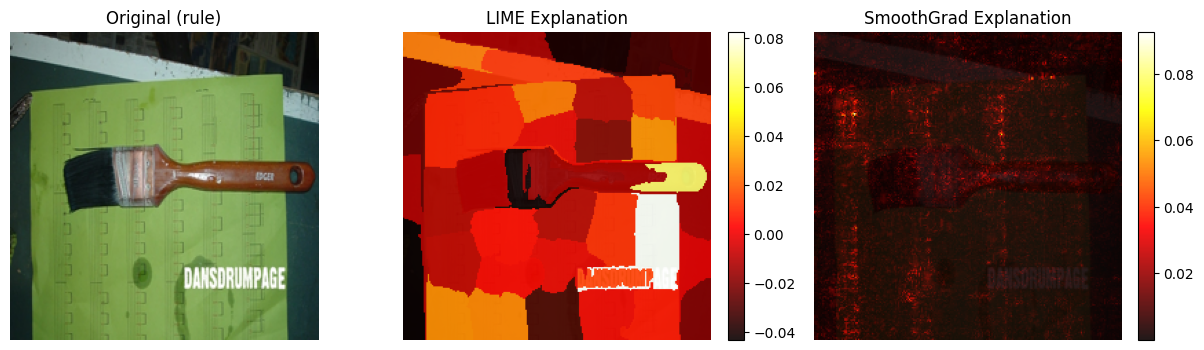

peacock.JPEG
Spearman correlation: 0.219
Kendall-Tau correlation: 0.150


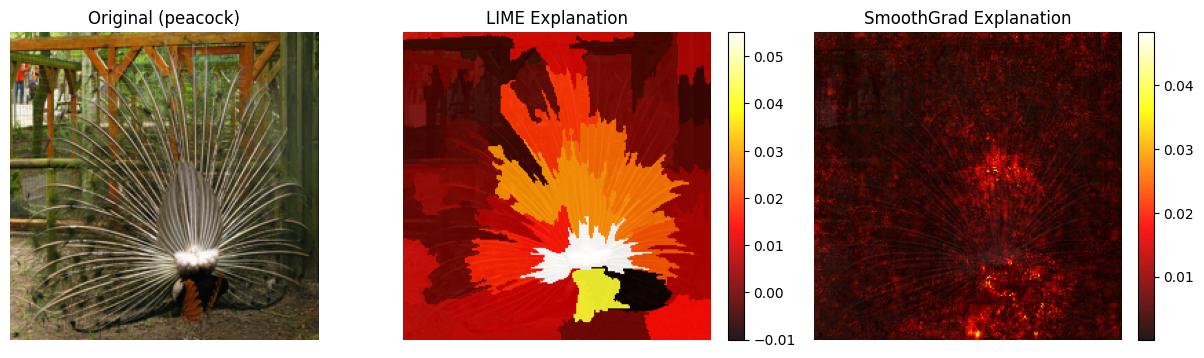

mountain_bike.JPEG
Spearman correlation: 0.178
Kendall-Tau correlation: 0.123


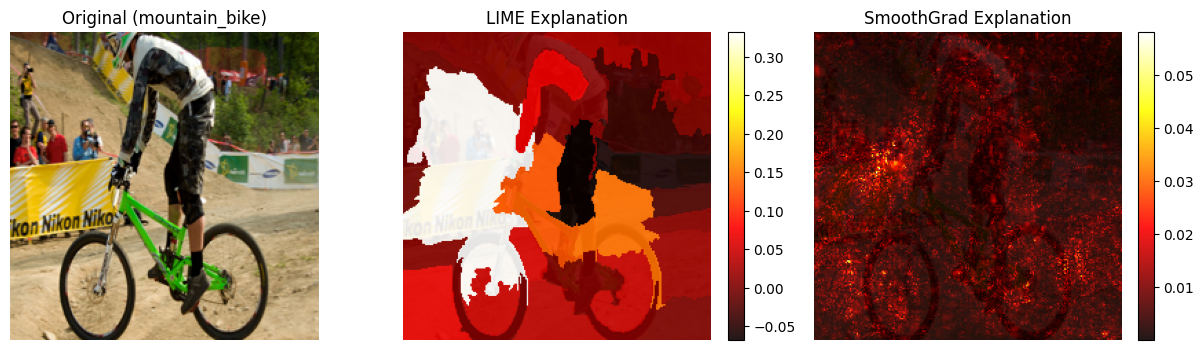

piggy_bank.JPEG
Spearman correlation: 0.121
Kendall-Tau correlation: 0.082


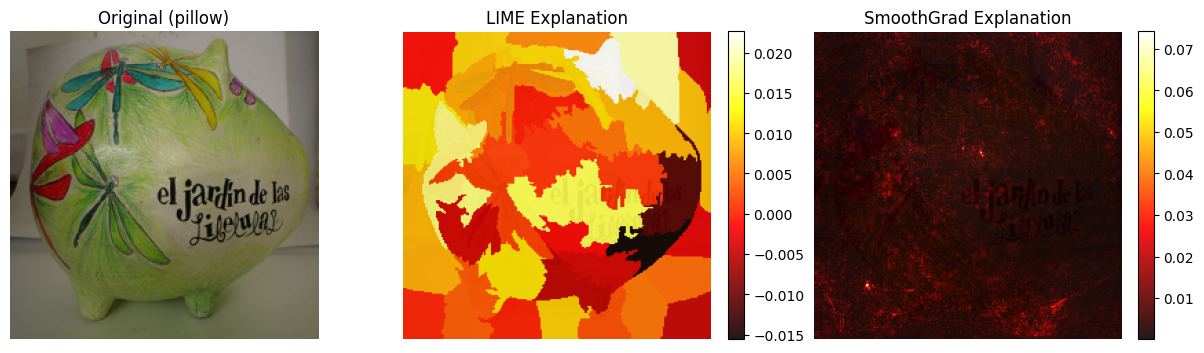

mousetrap.JPEG
Spearman correlation: 0.207
Kendall-Tau correlation: 0.140


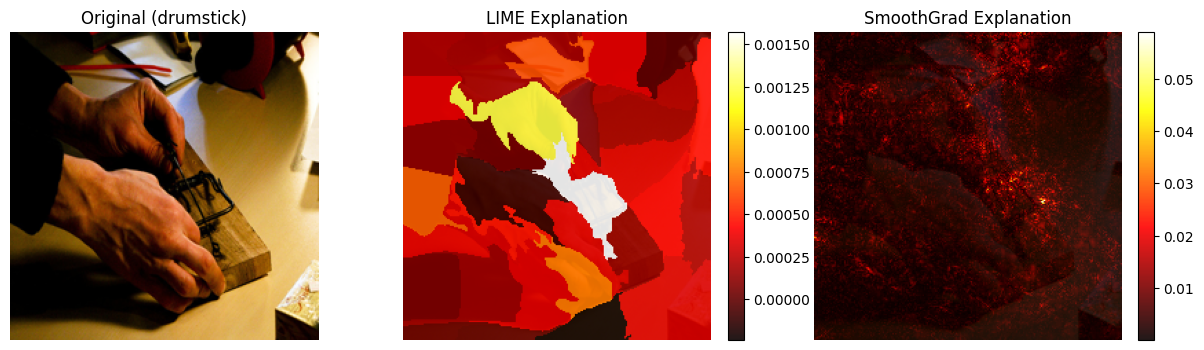

In [ ]:
from matplotlib import pyplot as plt
from scipy.stats import kendalltau, spearmanr

for img_path in image_paths:
    # Open and preprocess the image
    print(img_path)
    my_img = os.path.join(imagenet_path, img_path)
    input_image = Image.open(my_img).convert('RGB')

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    # Perform inference
    with torch.no_grad():
        output = model(input_batch)

    # Get the predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()
    predicted_synset = idx2synset[predicted_idx]
    predicted_label = idx2label[predicted_idx]


    # calculate attr with two methods
    lime_attr = lime_explain(model, input_image, predicted_idx)
    #lime_norm = (lime_attr - lime_attr.min()) / (lime_attr.max() - lime_attr.min())

    if torch.cuda.is_available():
        input_tensor = input_tensor.to('cuda')

    smooth_attr = smoothgrad_explain(model, input_tensor, predicted_idx)
    #smooth_norm = (smooth_attr - smooth_attr.min()) / (smooth_attr.max() - smooth_attr.min())

    lime_vals = lime_attr.flatten()
    smooth_vals = smooth_attr.flatten()
    spearman_corr, _ = spearmanr(lime_vals, smooth_vals)
    kendall_corr, _ = kendalltau(lime_vals, smooth_vals)

    print(f"Spearman correlation: {spearman_corr:.3f}")
    print(f"Kendall-Tau correlation: {kendall_corr:.3f}")


    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    axs[0].imshow(input_image.resize((224, 224)))
    axs[0].set_title(f"Original ({idx2label[predicted_idx]})")
    axs[0].axis('off')

    axs[1].imshow(input_image.resize((224, 224)))
    lime_img = axs[1].imshow(lime_attr, cmap='hot', alpha=0.9)
    axs[1].set_title("LIME Explanation")
    axs[1].axis('off')
    plt.colorbar(lime_img, ax=axs[1], fraction=0.05)


    axs[2].imshow(input_image.resize((224, 224)))
    smooth_img = axs[2].imshow(smooth_attr, cmap='hot', alpha=0.9)
    axs[2].set_title("SmoothGrad Explanation")
    axs[2].axis('off')
    plt.colorbar(smooth_img, ax=axs[2], fraction=0.05)


    plt.show()